In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt  
import numpy as np
from numpy.linalg import norm
from scipy import linalg

from random import seed
from random import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


pd.option_context('display.max_rows', None, 'display.max_columns', None)  # more options can be specified also
    
seed(1)

np.set_printoptions(precision=10, )
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)
%precision 10
!cp -r /content/drive/MyDrive/CS_480_680_DataSets /content

'''
Assignment name: Non-Linear regression techniques.
Problem: this data corresponds to samples from a 2D surface that you can plot to visualize how regression is working.
Format: there is one row per data instance and one column per attribute. The targets are real values.
'''

'\nAssignment name: Non-Linear regression techniques.\nProblem: this data corresponds to samples from a 2D surface that you can plot to visualize how regression is working.\nFormat: there is one row per data instance and one column per attribute. The targets are real values.\n'

In [3]:
# train.csv dataSet
tr_name = 'trainInput'
tr_label = 'trainTarget'
base_location = '/content/CS_480_680_DataSets/nonlinear_regression_dataset/'

train_1 = pd.read_csv(base_location + tr_name + '1.csv', header=None)
train_2 = pd.read_csv(base_location + tr_name + '2.csv', header=None)
train_3 = pd.read_csv(base_location + tr_name + '3.csv', header=None)
train_4 = pd.read_csv(base_location + tr_name + '4.csv', header=None)
train_5 = pd.read_csv(base_location + tr_name + '5.csv', header=None)
train_6 = pd.read_csv(base_location + tr_name + '6.csv', header=None)
train_7 = pd.read_csv(base_location + tr_name + '7.csv', header=None)
train_8 = pd.read_csv(base_location + tr_name + '8.csv', header=None)
train_9 = pd.read_csv(base_location + tr_name + '9.csv', header=None)
train_10 = pd.read_csv(base_location + tr_name + '10.csv', header=None)
test_data = pd.read_csv(base_location + 'testInput.csv', header=None)

train_1 = (train_1 - train_1.min())/(train_1.max()-train_1.min())
train_2 = (train_2 - train_2.min())/(train_2.max()-train_2.min())
train_3 = (train_3 - train_3.min())/(train_3.max()-train_3.min())
train_4 = (train_4 - train_4.min())/(train_4.max()-train_4.min())
train_5 = (train_5 - train_5.min())/(train_5.max()-train_5.min())
train_6 = (train_6 - train_6.min())/(train_6.max()-train_6.min())
train_7 = (train_7 - train_7.min())/(train_7.max()-train_7.min())
train_8 = (train_8 - train_8.min())/(train_8.max()-train_8.min())
train_9 = (train_9 - train_9.min())/(train_9.max()-train_9.min())
train_10 = (train_10 - train_10.min())/(train_10.max()-train_10.min())
test_data = (test_data - test_data.min())/(test_data.max()-test_data.min())

# Labels dataSet
labels_1 = pd.read_csv(base_location + tr_label + '1.csv', header=None)
labels_2 = pd.read_csv(base_location + tr_label + '2.csv', header=None)
labels_3 = pd.read_csv(base_location + tr_label + '3.csv', header=None)
labels_4 = pd.read_csv(base_location + tr_label + '4.csv', header=None)
labels_5 = pd.read_csv(base_location + tr_label + '5.csv', header=None)
labels_6 = pd.read_csv(base_location + tr_label + '6.csv', header=None)
labels_7 = pd.read_csv(base_location + tr_label + '7.csv', header=None)
labels_8 = pd.read_csv(base_location + tr_label + '8.csv', header=None)
labels_9 = pd.read_csv(base_location + tr_label + '9.csv', header=None)
labels_10 = pd.read_csv(base_location + tr_label + '10.csv', header=None)
test_labels = pd.read_csv(base_location + 'testTarget.csv', header=None)

In [4]:
train_set = [train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8, train_9, train_10]
labels_set = [labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10]

In [5]:
# Number of trainingdata splits
k_cross = 10

# List of dataFrames of the training data execluding the training data used for validation 
training_data = []
training_labels = []

# Same for validation data
validation_data = []
validation_labels = []

# Get training data and validation data as list of dataFrames
for i in range(k_cross):
  sub_train = [train_set[index] for index in range(k_cross) if index != i]
  sub_label = [labels_set[index] for index in range(k_cross) if index != i]
  
  # Concatenate all dataframes in the sub_train list to a single dataframe in order
  # to get a single training examples dataFrame with all examples in it.
  training_data.append(pd.concat(sub_train, ignore_index=True))
  training_labels.append(pd.concat(sub_label, ignore_index=True))

  validation_data.append(train_set[i])
  validation_labels.append(labels_set[i])

tot_train_data = pd.concat([training_data[0], validation_data[0]], ignore_index=True)
tot_train_labels = pd.concat([training_labels[0], validation_labels[0]], ignore_index=True)

In [6]:
def GET_examples_by_labels(df_data, df_labels, value):
  ''' This function gets sub set of examples that follow a certain label value.
      i.e. for a label; it takes binary values either 0 or 1.
      for a certain label value i.e. 0, get all the examples corresponding
      to this label value.
      Return: D_examples -> this is a sub dataset that contains all the examples
      corresponding to a single label value from the labels.
  '''
  
  # Get all the labels from the dataframe
  labels = df_labels['Label'].tolist()

  # find the location of 'value' in the feature values
  example_indices  = np.where(np.array(labels) == value)[0]

  # Return a DataFrame of all examples with labels are = value
  return df_data.iloc[example_indices].reset_index(drop=True)

In [7]:
def Polynomial_feature_extraction(degree, df_data):
  '''
  This function extracts the polynomial features. If the input has
  2 features, we can exract features for any polynomial degree i.e.
  for degree = 1 -> features: [1, a, b]. 
  for degree = 2 -> features: [1, a, a^2, b, b^2, ab]. 
  for degree = 3 -> features: [1, a, a^2, a^3, b, b^2, b^3, a*b, a^2 * b, b^2 * a]
  for degree = 4 -> features: [1, a, a^2, a^3, a^4, b, b^2, b^3, b^4, ab, a^2 * b,  a^3 * b, b^2 * a, b^3 * a, a^2 * b^2]
  '''
  num_locations = 0
  if degree == 1:
    num_locations = 3
  elif degree == 2:
    num_locations = 6
  elif degree == 3:
    num_locations = 10
  elif degree == 4:
    num_locations = 15
  else:
    print("Error; degree outof range")
    return

  num_examples = df_data.shape[0]
  arr = np.zeros([num_examples, num_locations])

  for index, row in df_data.iterrows():
    a = row[0]
    b = row[1]
    
    # Bias term
    arr[index][0] = 1 

    # loop over a
    i = 0
    for i in range(1, degree + 1):
      arr[index][i] = a ** i

    # loop over b
    for y in range(1, degree + 1):
      i += 1
      arr[index][i] = b ** y

    # a ^ z * b
    for z in range(1, degree):
      i += 1
      arr[index][i] = a ** z * b

    # b ^ z * a
    for z in range(2, degree):
      i += 1
      arr[index][i] = b ** z * a

    # a ** 2 * b ** 2
    if degree == 4:
      arr[index][i+1] = (a ** 2) * (b ** 2)

  return arr

In [8]:
def Get_train_targets(df_labels):
  '''
  This function returns a target vector of shape N x 1
  '''
  return np.squeeze(df_labels.to_numpy())

In [9]:
def Get_posterior_distribution_over_weights(phi_matrix, df_targets):

  '''
  This function calculates the mean and covariance matrices for the dataset.
  This function also assumes that the prior over the weights Pr(w) = N(0, I),
  "Zero mean, identity covariance matrix and constant noise precision Beta to be B = 1. "

  Equations:
  Mn = Beta * Sn * PHI.T * targets
  Sn-1 = alpha * Identity + Beta * PHI.T * PHI
  '''
  targets = np.squeeze(df_targets.to_numpy())

  Sn_inverse = np.dot(phi_matrix.T, phi_matrix) 

  Sn = np.linalg.inv(Sn_inverse)

  Mn = np.dot(np.dot(Sn, phi_matrix.T), targets).reshape(Sn.shape[0], 1)

  return Mn, Sn

def Bayesian_linear_regression_inference(df_train, df_test, df_labels, degree):
  
  train_array = Polynomial_feature_extraction(degree, df_train)
  
  mean, cova = Get_posterior_distribution_over_weights(train_array, df_labels)

  test_array = Polynomial_feature_extraction(degree, df_test)

  return np.dot(mean.T, test_array.T)

In [10]:
def Get_best_degree(degree):
  accuracy = []
  list_acc = []
  
  # Loop over all the k-validations
  for k in range(1, 10):
    
    y_pred = Bayesian_linear_regression_inference(training_data[k], validation_data[k],  training_labels[k], degree)

    # Store accuracy for the 10 cross validations for the current degree
    accuracy.append(mean_squared_error(y_pred.T, validation_labels[k]))

  print("MSE on average for degree: ", degree, ", is: ", (np.sum(np.array(accuracy))/k_cross))
  return  (np.sum(np.array(accuracy))/k_cross)

def test_Bayesian_linear_regression(df_train, df_test, df_train_labels, df_test_labels, degree):
  
  y_pred = Bayesian_linear_regression_inference(df_train, df_test, df_train_labels, degree)
  
  return mean_squared_error(y_pred.T, df_test_labels)

In [11]:
mse1 = Get_best_degree(degree = 1)
mse2 = Get_best_degree(degree = 2)
mse3 = Get_best_degree(degree = 3)
mse4 = Get_best_degree(degree = 4)

MSE on average for degree:  1 , is:  1.0705436612926187
MSE on average for degree:  2 , is:  0.7778335856993825
MSE on average for degree:  3 , is:  0.08896329790546124
MSE on average for degree:  4 , is:  0.08593005465038604


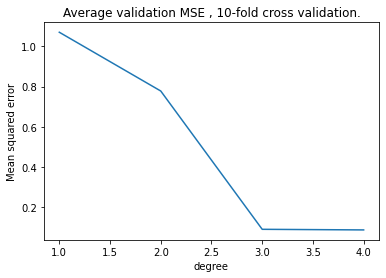

In [12]:
deg = [i for i in range(1, 5)]
plt.title("Average validation MSE , 10-fold cross validation.")
plt.xlabel("degree")
plt.ylabel("Mean squared error")
plt.plot(deg, [mse1, mse2, mse3, mse4])
plt.show()

In [13]:
test_Bayesian_linear_regression(tot_train_data, test_data, tot_train_labels, test_labels, 4)

0.0420389313